# SETUP

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  0.24.2
TF version:  2.8.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [2]:
X_train=np.uint8(np.load('./X_train_aug.npy'))
y_train=np.uint8(np.load('./y_train_aug.npy'))
X_valid=np.uint8(np.load('./X_valid.npy'))
y_valid=np.uint8(np.load('./y_valid.npy'))

In [3]:
X_valid=tf.reshape(X_valid,[-1,28,28,1])
X_train=tf.reshape(X_train,[-1,32,32,1])
X_valid_resize=np.uint8(tf.image.resize(X_valid, [32, 32]))
X_train_resize=np.uint8(tf.image.resize(X_train, [32, 32]))
X_train_resize.shape,X_valid_resize.shape,X_train.dtype

((1074263, 32, 32, 1), (164015, 32, 32, 1), tf.uint8)

In [4]:
X_train_final=keras.applications.mobilenet_v2.preprocess_input(np.array(X_train,np.float32))
X_valid_final=keras.applications.mobilenet_v2.preprocess_input(np.array(X_valid_resize,np.float32))

In [5]:
np.min(X_train)

0

In [6]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
    def on_epoch_end(self, batch, logs):
        print("lr: {}".format(self.model.optimizer.lr))

# SMV2SL

In [7]:
#황성현 
class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        initializer = tf.keras.initializers.HeNormal()
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, kernel_initializer=initializer,
                                padding="SAME"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME",kernel_initializer=initializer),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME",kernel_initializer=initializer),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,kernel_initializer=initializer,
                                padding="SAME"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",kernel_initializer=initializer),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",kernel_initializer=initializer),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [8]:
    #이승훈 황성현
    #SMV2SL

n_classes=62
smv2_SL=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[32,32,1]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=2,c=16,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=4,c=32,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=4,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=4,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=4,c=512,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    
smv2_SL.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
batch_size=128
smv2_SL.compile(loss="sparse_categorical_crossentropy",optimizer=opt,metrics=["accuracy"])

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 IRB1 (Inveted_Residual_Bloc  (None, 16, 16, 16)       2288      
 k)                                                              
                                                                 
 IRB2 (Inveted_Residual_Bloc  (None, 8, 8, 16)     

In [9]:
#황성현 전민재
from datetime import datetime
K = keras.backend
epochs=40
logs = "logs/" + datetime.now().strftime("SMV2SL_adam_best_lrsch_onecycle_aug_epoch40%Y%m%d-%H%M%S")
print(logs)
onecycle = OneCycleScheduler(len(X_train_resize) // batch_size * epochs, max_rate=0.003)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="SMV2SL_adam_best_lrsch_onecycle_aug_epoch40.h5",save_best_only=True)

history=smv2_SL.fit(X_train_final,y_train,
                   validation_data=(X_valid_final,y_valid),batch_size = batch_size, 
                   epochs=epochs,callbacks=[tboard_callback, check_best_cb,onecycle])

logs/SMV2SL_adam_best_lrsch_onecycle_aug_epoch4020220609-133452
Epoch 1/40
8393/8393 [==============================] - 135s 16ms/step - loss: 1.0129 - accuracy: 0.6979 - val_loss: 0.4826 - val_accuracy: 0.8256
Epoch 2/40
8393/8393 [==============================] - 132s 16ms/step - loss: 0.4761 - accuracy: 0.8304 - val_loss: 0.5511 - val_accuracy: 0.7945
Epoch 3/40
8393/8393 [==============================] - 133s 16ms/step - loss: 0.4356 - accuracy: 0.8421 - val_loss: 0.4016 - val_accuracy: 0.8534
Epoch 4/40
8393/8393 [==============================] - 131s 16ms/step - loss: 0.4156 - accuracy: 0.8479 - val_loss: 0.4165 - val_accuracy: 0.8418
Epoch 5/40
8393/8393 [==============================] - 130s 15ms/step - loss: 0.4040 - accuracy: 0.8513 - val_loss: 0.4667 - val_accuracy: 0.8355
Epoch 6/40
8393/8393 [==============================] - 130s 16ms/step - loss: 0.3962 - accuracy: 0.8535 - val_loss: 0.3824 - val_accuracy: 0.8574
Epoch 7/40
8393/8393 [==============================] 

8393/8393 [==============================] - 130s 15ms/step - loss: 0.3228 - accuracy: 0.8759 - val_loss: 0.6568 - val_accuracy: 0.8065
Epoch 28/40
8393/8393 [==============================] - 130s 15ms/step - loss: 0.3180 - accuracy: 0.8772 - val_loss: 0.4298 - val_accuracy: 0.8547
Epoch 29/40
8393/8393 [==============================] - 131s 16ms/step - loss: 0.3139 - accuracy: 0.8785 - val_loss: 0.9172 - val_accuracy: 0.7647
Epoch 30/40
8393/8393 [==============================] - 132s 16ms/step - loss: 0.3095 - accuracy: 0.8801 - val_loss: 0.3918 - val_accuracy: 0.8611
Epoch 31/40
8393/8393 [==============================] - 130s 15ms/step - loss: 0.3054 - accuracy: 0.8811 - val_loss: 0.3285 - val_accuracy: 0.8767
Epoch 32/40
8393/8393 [==============================] - 130s 16ms/step - loss: 0.3011 - accuracy: 0.8826 - val_loss: 0.5827 - val_accuracy: 0.8266
Epoch 33/40
8393/8393 [==============================] - 131s 16ms/step - loss: 0.2971 - accuracy: 0.8838 - val_loss: 0.4071

In [10]:
smv2_SL.save("SMV2SL_adam_best_lrsch_onecycle_aug_epoch40.h5")

In [15]:
smv2_SL_best=keras.models.load_model("SMV2SL_adam_best_lrsch_onecycle_aug_epoch40.h5",custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 16, 16, 32)
IRB2 : batch_input_shape = (None, 16, 16, 16)
IRB3 : batch_input_shape = (None, 8, 8, 16)
IRB4 : batch_input_shape = (None, 4, 4, 32)
IRB5 : batch_input_shape = (None, 2, 2, 64)
IRB6 : batch_input_shape = (None, 1, 1, 128)


In [16]:
smv2_SL_best.evaluate(X_valid_final,y_valid)

5126/5126 [==============================] - 30s 6ms/step - loss: 0.3275 - accuracy: 0.8801


[0.32748278975486755, 0.8801146149635315]

In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mpl.rc('axes', labelsize=4)
mpl.rc('xtick', labelsize=4)
mpl.rc('ytick', labelsize=4)
mpl.rc('font',size=1.5)

label=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']



In [20]:
y_predict=smv2_SL_best.predict(X_valid_final)
y_pred=np.argmax(y_predict,axis=1)

<Figure size 3000x2000 with 0 Axes>

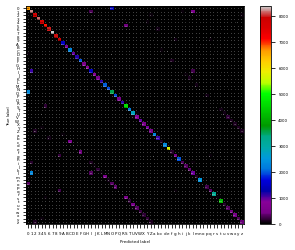

In [42]:
cf=confusion_matrix(y_valid,y_pred)
cm=ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=label)
plt.figure(dpi=500)
cm.plot(cmap="nipy_spectral")
plt.savefig("smv2_confusion_matrix.png",dpi=500)

In [43]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [45]:
%tensorboard --logdir logs/SMV2SL_adam_best_lrsch_onecycle_aug_epoch4020220609-133452
